# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string
import matplotlib.cm as cm
from cmcrameri import cm as cr

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles_depth_coded, plot_ptt_paths_depth_coded, _extract_interface

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
def calc_and_plot_YSE(ax, dataset, instant, x_position, clc=1.0, linestyle='-', color='xkcd:black', fill=False, alpha=0.8, scale_sr=1.0, zorder=50):
    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)

    x = np.linspace(0, Lx, Nx)
    z = np.linspace(Lz, 0, Nz)
    Z = np.linspace(Lz, 0, 8001)
    xx, zz  = np.meshgrid(x, z)
    dz = z[1] - z[0]

    idx = find_nearest(dataset.time, instant)
    Rhoi = dataset.density.isel(time=idx).values.T
    Ti = dataset.temperature.isel(time=idx).values.T

    #Now create the arrays for upper crust, lower crust and lithosphere interfaces
    h_air = 40.0e3
    topography_interface = _extract_interface(z, Z, Nx, Rhoi, 200.)# - h_air #m
    upper_crust_base = _extract_interface(z, Z, Nx, Rhoi, 2700.)# - h_air #m
    lower_crust_base = _extract_interface(z, Z, Nx, Rhoi, 2800.)# - h_air #m
    lithospheric_mantle_base = _extract_interface(z, Z, Nx, Rhoi, 3354.)# - h_air #m

    #We must find the x index for the given x_position
    idx_x = find_nearest(x, x_position)
    T_profile = Ti[:, idx_x] #take all values of T along z direction at idx_x position in x direction
    Rho_profile = Rhoi[:, idx_x]

    #interfaces at x position
    topography_interface_x_position = topography_interface[idx_x] - h_air #0 #np.round(topography_interface[idx_x]/1000)*1000 #m
    upper_crust_base_x_position = upper_crust_base[idx_x] - h_air #m
    lower_crust_base_x_position = lower_crust_base[idx_x] - h_air #m
    lithospheric_mantle_base_x_position = lithospheric_mantle_base[idx_x] - h_air #m

    Q = np.zeros_like(z)
    A = np.zeros_like(z)
    n = np.zeros_like(z)
    V = np.zeros_like(z)
    C = np.zeros_like(z)
    rho = np.zeros_like(z)
    phi0 = np.zeros_like(z)

    zaux = z - h_air

    #conditions for model layers based on depth and base of the layers
    air = zaux < topography_interface_x_position
    uc = (zaux>=topography_interface_x_position) & (zaux<upper_crust_base_x_position)
    lc = (zaux>=upper_crust_base_x_position) & (zaux<lower_crust_base_x_position)
    lm = (zaux>=lower_crust_base_x_position) & (zaux<=lithospheric_mantle_base_x_position)
    ast = zaux>lithospheric_mantle_base_x_position

    #conds2 based in density profile
    # air = Rho_profile<200.0
    # uc = (Rho_profile>=200.0) & (Rho_profile<2700.0)
    # lc = (Rho_profile>=2700.0) & (Rho_profile<2800.0)
    # lm = (Rho_profile>=2800.0) & (Rho_profile<3354.0)
    # ast = Rho_profile>=3354.0

    C[air] = 1.0
    C[uc] = 1.0
    C[lc] = clc
    C[lm] = 1.0
    C[ast] = 1.0

    rho[air] = 1.0
    rho[uc] = 2700.0
    rho[lc] = 2800.0
    rho[lm] = 3354.0
    rho[ast] = 3378.0

    A[air] = 1.0e-18
    A[uc] = 8.574E-28
    A[lc] = 8.574E-28
    A[lm] = 2.4168E-15
    A[ast] = 1.393e-14

    n[air] = 1.0
    n[uc] = 4.0
    n[lc] = 4.0
    n[lm] = 3.5
    n[ast] = 3.0

    Q[air] = 0.0
    Q[uc] = 222000.0
    Q[lc] = 222000.0
    Q[lm] = 540000.0
    Q[ast] = 429000.0

    V[air] = 0.0
    V[uc] = 0.0
    V[lc] = 0.0
    V[lm] = 25.0E-6
    V[ast] = 1.5e-05


    # # #yield strength envelope
    sr = 1.0E-15*scale_sr #strain rate - s-1
    # sr = 1.0E-14
    R = 8.314 #gas constant - J K−1 mol−1
    g = 10.0
    P = rho[::-1].cumsum()[::-1]*-g*dz

    phi = 2.0*np.pi/180.0
    c0 = 4.0E6
    sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

    phi = 15.0*np.pi/180.0
    c0 = 20.0E6
    sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

    TK = T_profile + 273
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))
    sigma_v = visc * sr
    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]

    # ax.plot(sigma_v/1e9,-(z)/1e3+h_air/1.0e3, linestyle=linestyle, color=color, label=f'{instant} Myr', zorder=zorder)
    ax.plot(sigma_v/1e9,-(z)/1e3+h_air/1.0e3, linestyle=linestyle, color=color, label=f'{scale_sr} cm/yr', zorder=zorder)


    if(fill==True):
        ax.fill_betweenx(-z/1000+h_air/1.0e3, 0, sigma_v/1e9, color=color, alpha=alpha, zorder=zorder)
    
    return T_profile, Rho_profile, z


In [3]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

scenarios = [#c=1 - homogeneous
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v3/RFT_DT230_Tp1350oC_v3_Clc1_checkered_false", 
            #c=1 - thinned
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v3/RFT_lithoramp_DT230_Tp1350oC_v3_Clc1_checkered_false",
            #c=1 - crust40km
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v3/RFT_DT230_Tp1350oC_crust40km_v3_Clc1_checkered_false",

            #c=10 - homogeneous
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v3/RFT_DT230_Tp1350oC_v3_Clc10_checkered_false",
            #c=10 - thinned
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v3/RFT_lithoramp_DT230_Tp1350oC_v3_Clc10_checkered_false",#v3 - ran until breakup (*Myr), but neet to run until the 40 Myr 
            #c=10 - crust40km
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v3/RFT_DT230_Tp1350oC_crust40km_v3_Clc10_checkered_false",
            ]
print(f"Comparing all {len(scenarios)} scenarios")

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)
dataset6 = read_datasets(scenarios[6], new_datasets)
dataset7 = read_datasets(scenarios[7], new_datasets)
dataset8 = read_datasets(scenarios[8], new_datasets)
dataset9 = read_datasets(scenarios[9], new_datasets)
dataset10 = read_datasets(scenarios[10], new_datasets)
dataset11 = read_datasets(scenarios[11], new_datasets)
dataset12 = read_datasets(scenarios[12], new_datasets)
dataset13 = read_datasets(scenarios[13], new_datasets)
dataset14 = read_datasets(scenarios[14], new_datasets)
dataset15 = read_datasets(scenarios[15], new_datasets)
dataset16 = read_datasets(scenarios[16], new_datasets)
dataset17 = read_datasets(scenarios[17], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

# print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")
trackdataset6 = xr.open_dataset(f"{scenarios[6]}/_track_xzPT_all_steps.nc")
trackdataset7 = xr.open_dataset(f"{scenarios[7]}/_track_xzPT_all_steps.nc")
trackdataset8 = xr.open_dataset(f"{scenarios[8]}/_track_xzPT_all_steps.nc")
trackdataset9 = xr.open_dataset(f"{scenarios[9]}/_track_xzPT_all_steps.nc")
trackdataset10 = xr.open_dataset(f"{scenarios[10]}/_track_xzPT_all_steps.nc")
trackdataset11 = xr.open_dataset(f"{scenarios[11]}/_track_xzPT_all_steps.nc")
trackdataset12 = xr.open_dataset(f"{scenarios[12]}/_track_xzPT_all_steps.nc")
trackdataset13 = xr.open_dataset(f"{scenarios[13]}/_track_xzPT_all_steps.nc")
trackdataset14 = xr.open_dataset(f"{scenarios[14]}/_track_xzPT_all_steps.nc")
trackdataset15 = xr.open_dataset(f"{scenarios[15]}/_track_xzPT_all_steps.nc")
trackdataset16 = xr.open_dataset(f"{scenarios[16]}/_track_xzPT_all_steps.nc")
trackdataset17 = xr.open_dataset(f"{scenarios[17]}/_track_xzPT_all_steps.nc")

#PTt data from McCarthy et al. (2020) and Muntener et al. (2009)
McCarthy_data = pd.read_excel(f"PTt_Data/McCarthy_Fig9_datasets.xlsx")
Muntener_data = pd.read_excel(f"PTt_Data/Muntener_Fig16_datasets.xlsx")
Johanesen_data = pd.read_excel(f"PTt_Data/Johanesen_Fig7_datasets.xlsx")

datasets = [#Clc=1
            [dataset0, dataset1, dataset2],
            [dataset3, dataset4, dataset5],
            [dataset6, dataset7, dataset8],
            #Clc=10
            [dataset9, dataset10, dataset11],
            [dataset12, dataset13, dataset14],
            [dataset15, dataset16, dataset17]]

trackdatasets = [#Clc=1
                 [trackdataset0, trackdataset1, trackdataset2],
                 [trackdataset3, trackdataset4, trackdataset5],
                 [trackdataset6, trackdataset7, trackdataset8],
                #Clc=10
                 [trackdataset9, trackdataset10, trackdataset11],
                 [trackdataset12, trackdataset13, trackdataset14],
                 [trackdataset15, trackdataset16, trackdataset17]]

Comparing all 18 scenarios


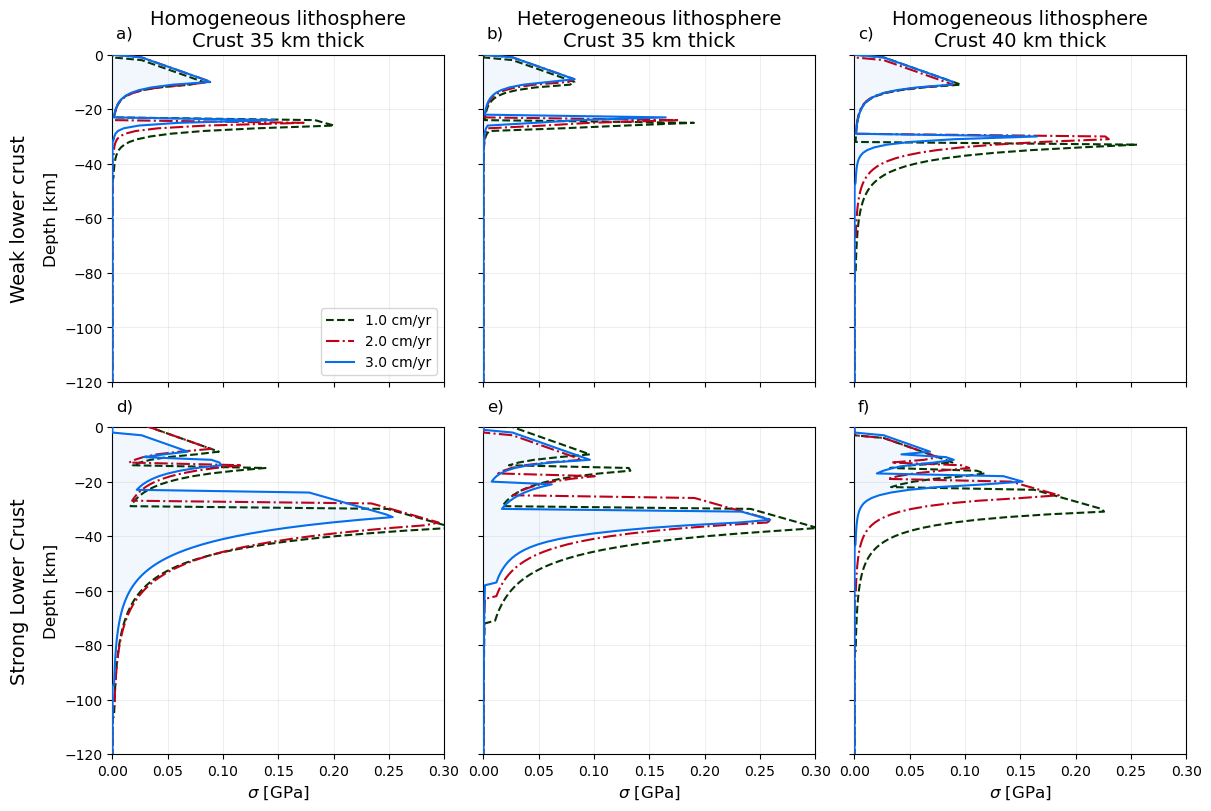

In [20]:
# x_positions = [#v1    v2   v3
#                 850.0e3, 850.0e3, 850.0e3, #c=1 - homogeneous
#                 910.0e3, 900.0e3, 880.0e3, #c=10 - homogeneous ok

#                 850.0e3, 840.0e3, 840.0e3, #c=1 - thinned
#                 890.0e3, 860.0e3, 850.0e3, #c=10 - thinned

#                 860.0e3, 860.0e3, 850.0e3, #c=1 - crust40km
#                 900.0e3, 900.0e3, 900.0e3 #c=10 - crust40km 
# ]

x_positions = [#v1    v2   v3
                [850.0e3, 850.0e3, 850.0e3], #c=1 - homogeneous
                [850.0e3, 840.0e3, 840.0e3], #c=1 - thinned
                [860.0e3, 860.0e3, 850.0e3], #c=1 - crust40km

                [910.0e3, 900.0e3, 880.0e3], #c=10 - homogeneous ok
                [890.0e3, 860.0e3, 850.0e3], #c=10 - thinned
                [900.0e3, 900.0e3, 900.0e3] #c=10 - crust40km 
]

plt.close()
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
amount_extension = 90.0e3 #m
velocities = [1.0, 2.0, 3.0] #cm/yr
color_velocities = ['xkcd:dark green', 'xkcd:scarlet', 'xkcd:cerulean blue']
# color_velocities = ['xkcd:violet', 'xkcd:orange', 'xkcd:dark green']
linestyles = ['--', '-.', '-']
zorders = [58, 59, 60]

for ax, dataset_group, x_positions_group in zip(axs, datasets, x_positions):
    if(ax.get_subplotspec().is_first_row()): #first column
        clc=1.0
    if(ax.get_subplotspec().is_last_row()): #second column
        clc=10.0

    for dataset, x_position, velocity, color_velocity, linestyle, zorder in zip(dataset_group, x_positions_group, velocities, color_velocities, linestyles, zorders):
        instant = (amount_extension/(velocity*1.0e-2))/1.0e6 if ax != axs[5] else (2*amount_extension/(velocity*1.0e-2))/1.0e6 #Myr - converting velocity from cm/yr to m/s and then the result to Myr
        # print(instant)
        if(velocity==3.0):
            fill = True
        else:
            fill = False

        T_profile, Rho_profile, z = calc_and_plot_YSE(ax, dataset, instant=instant, x_position=x_position, clc=clc, linestyle=linestyle, color=color_velocity, fill=fill, alpha=0.05, scale_sr=velocity, zorder=zorder)

line_labels = np.asarray(list(string.ascii_lowercase)[0: len(datasets)])
ylims = np.array([-120, 0]) #
xlims = np.array([0, 0.3])
xpos = 0.01
ypos = 1.05
fsize = 12

xposClc = -0.28
yposClc = 0.5
fsizeClc = 14

axs[0].set_title(f'Homogeneous lithosphere\nCrust 35 km thick', fontsize=14)
axs[1].set_title(f'Heterogeneous lithosphere\nCrust 35 km thick', fontsize=14)
axs[2].set_title(f'Homogeneous lithosphere\nCrust 40 km thick', fontsize=14)

for ax, number, line_label in zip(axs, range(len(axs)), line_labels):
    ax.text(xpos, ypos, f"{line_label})", transform=ax.transAxes, fontsize=fsize, zorder=60)
    ax.grid('-k', alpha=0.2)
    # ax.text(-0.2, 1.1, f"{string.ascii_lowercase[number]})", transform=ax.transAxes, fontsize=12)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    if(ax.get_subplotspec().is_last_row()):
        ax.set_xlabel(f'$\sigma$ [GPa]', fontsize=12)
    else:
        ax.set_xlabel('')

    if(ax.get_subplotspec().is_first_col()):
        ax.set_ylabel('Depth [km]', fontsize=12)
        if(ax.get_subplotspec().is_first_row()): #first column
            ax.text(xposClc, yposClc, f"Weak lower crust", transform=ax.transAxes, fontsize=fsizeClc, rotation=90, ha='center', va='center')
        if(ax.get_subplotspec().is_last_row()): #second column
            ax.text(xposClc, yposClc, f"Strong Lower Crust", transform=ax.transAxes, fontsize=fsizeClc, rotation=90, ha='center', va='center')
    else:
        ax.set_ylabel('')

axs[0].legend(loc='lower right', fontsize=10)

figname = f"YSE_Comparison_all_RFT"
fig.savefig(f'figures/{figname}.png', dpi=300)
fig.savefig(f'figures/{figname}.pdf', dpi=300)

In [ ]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

scenarios = [#c=1 - homogeneous
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v3/RFT_DT230_Tp1350oC_v3_Clc1_checkered_false", 
            #c=10 - homogeneous
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v3/RFT_DT230_Tp1350oC_v3_Clc10_checkered_false",
            #c=1 - thinned
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v3/RFT_lithoramp_DT230_Tp1350oC_v3_Clc1_checkered_false",
            #c=10 - thinned
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v3/RFT_lithoramp_DT230_Tp1350oC_v3_Clc10_checkered_false",#v3 - ran until breakup (*Myr), but neet to run until the 40 Myr 
            #c=1 - crust40km
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v3/RFT_DT230_Tp1350oC_crust40km_v3_Clc1_checkered_false",
            #c=10 - crust40km
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v3/RFT_DT230_Tp1350oC_crust40km_v3_Clc10_checkered_false",
            ]
print(f"Comparing all {len(scenarios)} scenarios")

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)
dataset6 = read_datasets(scenarios[6], new_datasets)
dataset7 = read_datasets(scenarios[7], new_datasets)
dataset8 = read_datasets(scenarios[8], new_datasets)
dataset9 = read_datasets(scenarios[9], new_datasets)
dataset10 = read_datasets(scenarios[10], new_datasets)
dataset11 = read_datasets(scenarios[11], new_datasets)
dataset12 = read_datasets(scenarios[12], new_datasets)
dataset13 = read_datasets(scenarios[13], new_datasets)
dataset14 = read_datasets(scenarios[14], new_datasets)
dataset15 = read_datasets(scenarios[15], new_datasets)
dataset16 = read_datasets(scenarios[16], new_datasets)
dataset17 = read_datasets(scenarios[17], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

# print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")
trackdataset6 = xr.open_dataset(f"{scenarios[6]}/_track_xzPT_all_steps.nc")
trackdataset7 = xr.open_dataset(f"{scenarios[7]}/_track_xzPT_all_steps.nc")
trackdataset8 = xr.open_dataset(f"{scenarios[8]}/_track_xzPT_all_steps.nc")
trackdataset9 = xr.open_dataset(f"{scenarios[9]}/_track_xzPT_all_steps.nc")
trackdataset10 = xr.open_dataset(f"{scenarios[10]}/_track_xzPT_all_steps.nc")
trackdataset11 = xr.open_dataset(f"{scenarios[11]}/_track_xzPT_all_steps.nc")
trackdataset12 = xr.open_dataset(f"{scenarios[12]}/_track_xzPT_all_steps.nc")
trackdataset13 = xr.open_dataset(f"{scenarios[13]}/_track_xzPT_all_steps.nc")
trackdataset14 = xr.open_dataset(f"{scenarios[14]}/_track_xzPT_all_steps.nc")
trackdataset15 = xr.open_dataset(f"{scenarios[15]}/_track_xzPT_all_steps.nc")
trackdataset16 = xr.open_dataset(f"{scenarios[16]}/_track_xzPT_all_steps.nc")
trackdataset17 = xr.open_dataset(f"{scenarios[17]}/_track_xzPT_all_steps.nc")

#PTt data from McCarthy et al. (2020) and Muntener et al. (2009)
McCarthy_data = pd.read_excel(f"PTt_Data/McCarthy_Fig9_datasets.xlsx")
Muntener_data = pd.read_excel(f"PTt_Data/Muntener_Fig16_datasets.xlsx")
Johanesen_data = pd.read_excel(f"PTt_Data/Johanesen_Fig7_datasets.xlsx")

datasets = [dataset0, dataset1, dataset2,
            dataset3, dataset4, dataset5,
            dataset6, dataset7, dataset8,
            dataset9, dataset10, dataset11,
            dataset12, dataset13, dataset14,
            dataset15, dataset16, dataset17]

trackdatasets = [trackdataset0, trackdataset1, trackdataset2,
                 trackdataset3, trackdataset4, trackdataset5,
                 trackdataset6, trackdataset7, trackdataset8,
                 trackdataset9, trackdataset10, trackdataset11,
                 trackdataset12, trackdataset13, trackdataset14,
                 trackdataset15, trackdataset16, trackdataset17]

In [ ]:
##################################################################################################################
plt.close()
fig, axs = plt.subplots(6, 3, figsize=(8,12), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

Clcs = [1.0, 1.0, 1.0, 
        10.0, 10.0, 10.0,
        1.0, 1.0, 1.0,
        10.0, 10.0, 10.0,
        1.0, 1.0, 1.0,
        10.0, 10.0, 10.0]

# time_lithospheric_breakbups = [#v1    v2   v3
                            #    12.85, 5.50, 3.53, #c=1 - homogeneous
                            #    24.78, 8.98, 5.51, #c=10 - homogeneous ok

                            #    12.82, 6.06, 4.28, #c=1 - thinned
                            #    26.28, 9.64, 10.0, #c=10 - thinned RUNNING

                            #    15.99, 6.00, 3.56, #c=1 - crust40km
                            #    36.87, 12.26, 10.0 #c=10 - crust40km RUNNING                   
# ]

# x_positions = [#v1    v2   v3
#                 850.0e3, 850.0e3, 850.0e3, #c=1 - homogeneous
#                 910.0e3, 910.e3, 880.0e3, #c=10 - homogeneous ok

#                 850.0e3, 850.0e3, 850.0e3, #c=1 - thinned
#                 900.0e3, 870.0e3, 870.0e3, #c=10 - thinned RUNNING

#                 870.0e3, 860.0e3, 850.0e3, #c=1 - crust40km
#                 900.0e3, 900.0e3, 900.0e3 #c=10 - crust40km RUNNING
# ]


time_lithospheric_breakbups = [#v1    v2   v3
                               11.70, 5.00, 3.53, #c=1 - homogeneous
                               17.63, 8.00, 5.51, #c=10 - homogeneous ok

                               7.31, 3.31, 2.52, #c=1 - thinned
                               13.32, 6.11, 4.18, #c=10 - thinned

                               15.99, 6.00, 3.96, #c=1 - crust40km
                               24.55, 10.50, 6.74 #c=10 - crust40km                    
]

x_positions = [#v1    v2   v3
                850.0e3, 850.0e3, 850.0e3, #c=1 - homogeneous
                910.0e3, 900.0e3, 880.0e3, #c=10 - homogeneous ok

                850.0e3, 840.0e3, 840.0e3, #c=1 - thinned
                890.0e3, 860.0e3, 850.0e3, #c=10 - thinned

                860.0e3, 860.0e3, 850.0e3, #c=1 - crust40km
                900.0e3, 900.0e3, 900.0e3 #c=10 - crust40km 
]

velocities = [1, 2, 3]*6
amount_extension = 70.0e3 #m

line_labels = np.asarray(list(string.ascii_lowercase)[0: len(scenarios)])

for ax, dataset, clc, time_breakup, x_position, velocity in zip(axs, datasets, Clcs, time_lithospheric_breakbups, x_positions, velocities):
    T_profile, Rho_profile, z = calc_and_plot_YSE(ax, dataset, instant=0.5, x_position=x_position, clc=clc, linestyle='--', color='xkcd:cerulean blue', fill=True, alpha=0.1, scale_sr=velocity)

    instant = (amount_extension/(velocity*1.0e-2))/1.0e6 #Myr - converting velocity from cm/yr to m/s and then the result to Myr
    # instant = time_breakup - dt_retreat
    T_profile, Rho_profile, z = calc_and_plot_YSE(ax, dataset, instant=np.round(instant,2), x_position=x_position, clc=clc, linestyle='-', color='xkcd:scarlet', fill=True, alpha=0.1, scale_sr=velocity)
    ax.legend(loc='upper right', fontsize=8)
    ax.text(0.15, 0.03, f"Position of YSE: {int(x_position/1.0e3)} km", transform=ax.transAxes, fontsize=8)

ylims = np.array([-120, 0]) #
xlims = np.array([0, 0.4])
xpos = 0.01
ypos = 1.05
fsize = 10
for ax, number, line_label in zip(axs, range(len(axs)), line_labels):
    ax.text(xpos, ypos, f"{line_label})", transform=ax.transAxes, fontsize=fsize, zorder=60)
    ax.grid('-k', alpha=0.2)
    # ax.text(-0.2, 1.1, f"{string.ascii_lowercase[number]})", transform=ax.transAxes, fontsize=12)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel(f'$\sigma$ [GPa]', fontsize=10) if  ax.get_subplotspec().is_last_row() else ax.set_xlabel('')
    ax.set_ylabel('Depth [km]', fontsize=10) if ax.get_subplotspec().is_first_col() else ax.set_ylabel('')


axs[0].set_title(f'v = 1 cm/yr', fontsize=12)
axs[1].set_title(f'v = 2 cm/yr', fontsize=12)
axs[2].set_title(f'v = 3 cm/yr', fontsize=12)

xpos = -0.48
ypos = 0.5
fsize = 12
axs[0].text(xpos, ypos, f"Homogeneous\nWeak lower crust\nCrust 35 km thick", transform=axs[0].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[3].text(xpos, ypos, f"Homogeneous\nStrong Lower Crust\nCrust 35 km thick", transform=axs[3].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[6].text(xpos, ypos, f"Thinned\nWeak lower crust\nCrust 35 km thick", transform=axs[6].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[9].text(xpos, ypos, f"Thinned\nStrong Lower Crust\nCrust 35 km thick", transform=axs[9].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[12].text(xpos, ypos, f"Homogeneous\nWeak lower crust\nCrust 40 km thick", transform=axs[12].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[15].text(xpos, ypos, f"Homogeneous\nStrong Lower Crust\nCrust 40 km thick", transform=axs[15].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')


figname = f"YSE_Comparison_all_RFT"
fig.savefig(f'figures/{figname}.png', dpi=300)
fig.savefig(f'figures/{figname}.pdf', dpi=300)

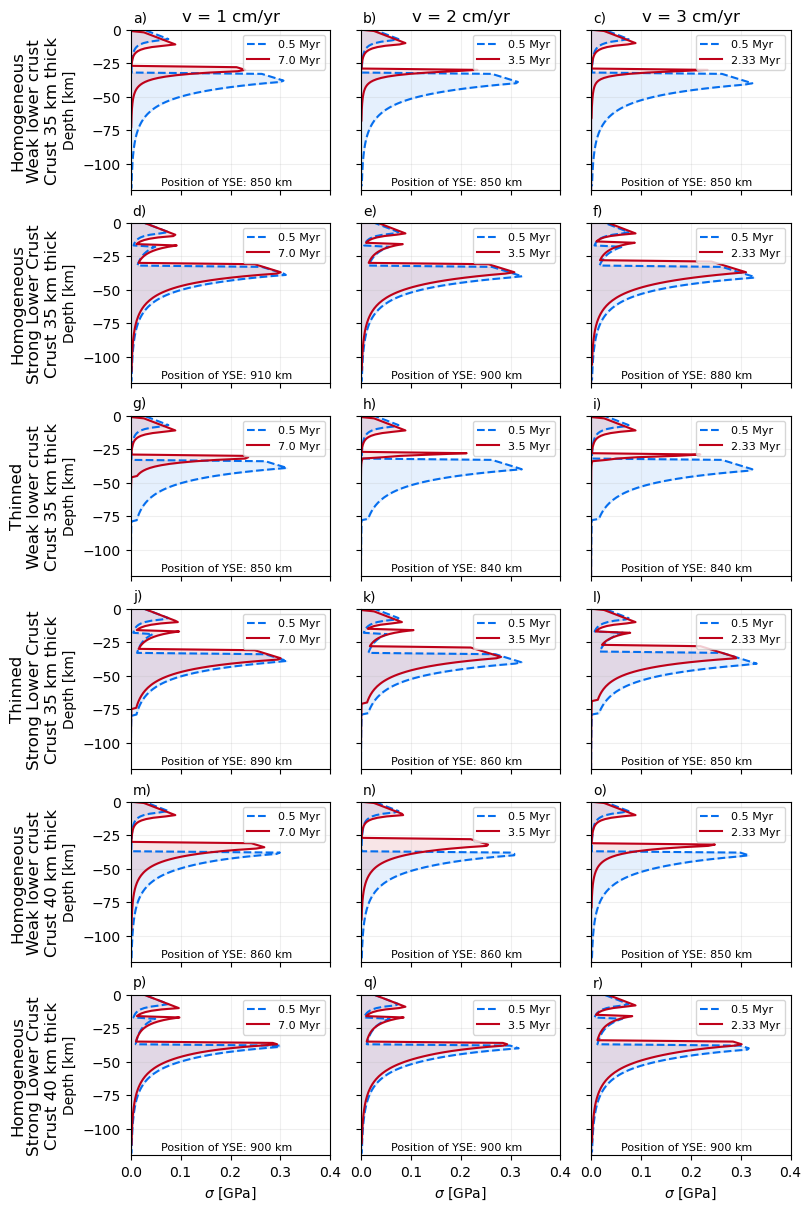

In [24]:
##################################################################################################################
plt.close()
fig, axs = plt.subplots(6, 3, figsize=(8,12), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

Clcs = [1.0, 1.0, 1.0, 
        10.0, 10.0, 10.0,
        1.0, 1.0, 1.0,
        10.0, 10.0, 10.0,
        1.0, 1.0, 1.0,
        10.0, 10.0, 10.0]

# time_lithospheric_breakbups = [#v1    v2   v3
                            #    12.85, 5.50, 3.53, #c=1 - homogeneous
                            #    24.78, 8.98, 5.51, #c=10 - homogeneous ok

                            #    12.82, 6.06, 4.28, #c=1 - thinned
                            #    26.28, 9.64, 10.0, #c=10 - thinned RUNNING

                            #    15.99, 6.00, 3.56, #c=1 - crust40km
                            #    36.87, 12.26, 10.0 #c=10 - crust40km RUNNING                   
# ]

# x_positions = [#v1    v2   v3
#                 850.0e3, 850.0e3, 850.0e3, #c=1 - homogeneous
#                 910.0e3, 910.e3, 880.0e3, #c=10 - homogeneous ok

#                 850.0e3, 850.0e3, 850.0e3, #c=1 - thinned
#                 900.0e3, 870.0e3, 870.0e3, #c=10 - thinned RUNNING

#                 870.0e3, 860.0e3, 850.0e3, #c=1 - crust40km
#                 900.0e3, 900.0e3, 900.0e3 #c=10 - crust40km RUNNING
# ]


time_lithospheric_breakbups = [#v1    v2   v3
                               11.70, 5.00, 3.53, #c=1 - homogeneous
                               17.63, 8.00, 5.51, #c=10 - homogeneous ok

                               7.31, 3.31, 2.52, #c=1 - thinned
                               13.32, 6.11, 4.18, #c=10 - thinned

                               15.99, 6.00, 3.96, #c=1 - crust40km
                               24.55, 10.50, 6.74 #c=10 - crust40km                    
]

x_positions = [#v1    v2   v3
                850.0e3, 850.0e3, 850.0e3, #c=1 - homogeneous
                910.0e3, 900.0e3, 880.0e3, #c=10 - homogeneous ok

                850.0e3, 840.0e3, 840.0e3, #c=1 - thinned
                890.0e3, 860.0e3, 850.0e3, #c=10 - thinned

                860.0e3, 860.0e3, 850.0e3, #c=1 - crust40km
                900.0e3, 900.0e3, 900.0e3 #c=10 - crust40km 
]

velocities = [1, 2, 3]*6
amount_extension = 70.0e3 #m

line_labels = np.asarray(list(string.ascii_lowercase)[0: len(scenarios)])

for ax, dataset, clc, time_breakup, x_position, velocity in zip(axs, datasets, Clcs, time_lithospheric_breakbups, x_positions, velocities):
    T_profile, Rho_profile, z = calc_and_plot_YSE(ax, dataset, instant=0.5, x_position=x_position, clc=clc, linestyle='--', color='xkcd:cerulean blue', fill=True, alpha=0.1, scale_sr=velocity)

    instant = (amount_extension/(velocity*1.0e-2))/1.0e6 #Myr - converting velocity from cm/yr to m/s and then the result to Myr
    # instant = time_breakup - dt_retreat
    T_profile, Rho_profile, z = calc_and_plot_YSE(ax, dataset, instant=np.round(instant,2), x_position=x_position, clc=clc, linestyle='-', color='xkcd:scarlet', fill=True, alpha=0.1, scale_sr=velocity)
    ax.legend(loc='upper right', fontsize=8)
    ax.text(0.15, 0.03, f"Position of YSE: {int(x_position/1.0e3)} km", transform=ax.transAxes, fontsize=8)

ylims = np.array([-120, 0]) #
xlims = np.array([0, 0.4])
xpos = 0.01
ypos = 1.05
fsize = 10
for ax, number, line_label in zip(axs, range(len(axs)), line_labels):
    ax.text(xpos, ypos, f"{line_label})", transform=ax.transAxes, fontsize=fsize, zorder=60)
    ax.grid('-k', alpha=0.2)
    # ax.text(-0.2, 1.1, f"{string.ascii_lowercase[number]})", transform=ax.transAxes, fontsize=12)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel(f'$\sigma$ [GPa]', fontsize=10) if  ax.get_subplotspec().is_last_row() else ax.set_xlabel('')
    ax.set_ylabel('Depth [km]', fontsize=10) if ax.get_subplotspec().is_first_col() else ax.set_ylabel('')


axs[0].set_title(f'v = 1 cm/yr', fontsize=12)
axs[1].set_title(f'v = 2 cm/yr', fontsize=12)
axs[2].set_title(f'v = 3 cm/yr', fontsize=12)

xpos = -0.48
ypos = 0.5
fsize = 12
axs[0].text(xpos, ypos, f"Homogeneous\nWeak lower crust\nCrust 35 km thick", transform=axs[0].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[3].text(xpos, ypos, f"Homogeneous\nStrong Lower Crust\nCrust 35 km thick", transform=axs[3].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[6].text(xpos, ypos, f"Thinned\nWeak lower crust\nCrust 35 km thick", transform=axs[6].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[9].text(xpos, ypos, f"Thinned\nStrong Lower Crust\nCrust 35 km thick", transform=axs[9].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[12].text(xpos, ypos, f"Homogeneous\nWeak lower crust\nCrust 40 km thick", transform=axs[12].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')
axs[15].text(xpos, ypos, f"Homogeneous\nStrong Lower Crust\nCrust 40 km thick", transform=axs[15].transAxes, fontsize=fsize, rotation=90, ha='center', va='center')


figname = f"YSE_Comparison_all_RFT"
fig.savefig(f'figures/{figname}.png', dpi=300)
fig.savefig(f'figures/{figname}.pdf', dpi=300)

dataset = datasets[3]
clc=10
time_breakup = 16
x_position = 910.0e3
plt.close()
fig, axs = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True, sharey=True)
axs[0].set_xlim(0, 0.5)
axs[0].set_ylim(-120, 0)
axs[0].set_xlabel(f'$\sigma$ [GPa]', fontsize=10)
axs[0].set_ylabel('Depth [km]', fontsize=10)
axs[0].grid('-k', alpha=0.2)

T_profile0, Rho_profile0, z = calc_and_plot_YSE(axs[0], dataset, instant=0, x_position=x_position, clc=clc, linestyle='--', color='xkcd:cerulean blue', fill=True, alpha=0.1)
T_profile, Rho_profile, z = calc_and_plot_YSE(axs[0], dataset, instant=np.round(time_breakup,2), x_position=x_position, clc=clc, linestyle='-', color='xkcd:scarlet', fill=True, alpha=0.1)
axs[0].legend(loc='upper right', fontsize=8)

axs[1].plot(T_profile0, -z/1e3+40, '-b', label=f'{0} Myr')
axs[1].plot(T_profile, -z/1e3+40, '-r', label=f'{np.round(time_breakup,2)} Myr')
axs[1].set_xlim(0, 1500)
axs[1].set_xlabel('Temperature [°C]', fontsize=10)
axs[1].grid('-k', alpha=0.2)
axs[1].legend(loc='upper right', fontsize=8)

axs[2].plot(Rho_profile0, -z/1e3+40, '-b', label=f'{0} Myr')
axs[2].plot(Rho_profile, -z/1e3+40, '-r', label=f'{np.round(time_breakup,2)} Myr')
axs[2].set_xlim(0, 3500)
axs[2].set_xlabel('Density [kg/m³]', fontsize=10)
axs[2].grid('-k', alpha=0.2)
axs[2].legend(loc='upper right', fontsize=8)

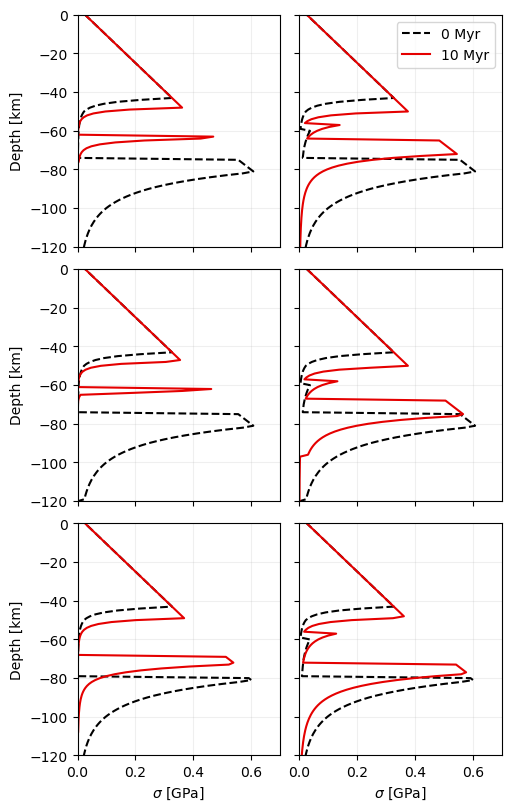

In [ ]:
data = dataset3
plt.close()
fig, axt = plt.subplots(1, 1, figsize=(6,8))
T_profile0, Rho_profile0, z0 = calc_and_plot_YSE(axt, data, instant=0.0, x_position=910.0e3, clc=10, linestyle='--', color='xkcd:cerulean blue', fill=True, alpha=0.1)
T_profile, Rho_profile, z = calc_and_plot_YSE(axt, data, instant=2, x_position=910.0e3, clc=10, linestyle='--', color='xkcd:scarlet', fill=True, alpha=0.1)
axt.set_ylim(-120, 0)

In [ ]:
plt.plot(T_profile0, -(z0 - 40.0e3)/1000.0, color='xkcd:cerulean blue', label='0 Myr', linewidth=2.5)
plt.plot(T_profile, -(z - 40.0e3)/1000.0, color='xkcd:scarlet', label='2 Myr', linewidth=2.5)
plt.ylim(-120, 0)
plt.legend()

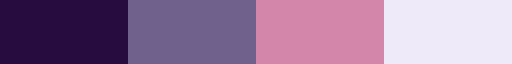

In [16]:
original_cmap = cr.acton
ncolors = 4
resampledcmap = original_cmap.resampled(ncolors)
colors_list = [resampledcmap(i) for i in range(ncolors)]
colors_list = colors_list[1:-1:1]
resampledcmap